# Computer Exercise 2
## Transfer function models and prediction

Time Series Analysis  
Lund University, Fall 2025

In this computer exercise, we will work with input-output relations, as well as prediction in time series models. Firstly, you will be acquainted with time series having an exogenous input, having to analyze the impulse response of such a system and from it build a suitable model. Secondly, we will examine how one can predict a time series, perhaps the most important application of time series modeling. You will be expected to make predictions of all models introduced in this course.

## Preparations before the lab

Review chapters 3, 4, and carefully read chapter 6 in the course textbook. Make sure to read section 4.5 in particular, as it deals with transfer function models, as well as this entire computer exercise guide.

Answers to some of the computer exercise will be graded using the course's *Mozquizto* page. Ensure that you can access the system before the exercise and answer the preparatory questions as well as (at least) three of numbered exercise questions below *before the exercise*.

You can find the *Mozquizto* system at <https://quizms.maths.lth.se>

It should be stressed that a thorough understanding of the material in this exercise is important to be able to complete the course project, and we encourage you to discuss any questions you might have on the exercises with the teaching staff. This will save you a lot of time when you start working with the project!

You are allowed to solve the exercise in groups of two, but not more. Please respect this.

In [1]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import sys
import os
import importlib
import scipy.io

# Add path to tsa_lth library
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'TimeSeriesAnalysis-main', 'TimeSeriesAnalysis-main')))

from tsa_lth.analysis import plotACFnPACF, normplot, pzmap, kovarians
from tsa_lth.modelling import estimateARMA, polydiv, estimateBJ, PEM
from tsa_lth.tests import whiteness_test, check_if_normal
from scipy.stats import norm

# Set data directory
DATA_DIR = os.path.join(os.getcwd(), '..', 'data')


# Function to compute cross correlation, xcorr function had the wrong input order of x and y. Also had a lag shift due to filtering but this works. 
def compute_ccf(x, y, maxlag):
    Cxy = np.correlate(y - np.mean(y), x - np.mean(x), mode='full')
    Cxy = Cxy / (np.std(y) * np.std(x) * len(y))
    lags = np.arange(-maxlag, maxlag + 1)
    mid = len(Cxy) // 2
    Cxy = Cxy[mid - maxlag:mid + maxlag + 1]
    return lags, Cxy


## Lab Tasks

### 2.1 Modeling of an exogenous input signal

In this and in the next section, you will work with modeling of input-output relations, both using the ARMAX model and the transfer function model framework. As modeling of a signal which has an exogenous input (an input which is known, i.e., deterministic) is generally more complex than the common time series models encountered so far in this course, one must take care and proceed with caution. Often very simple models of a low order will suffice, while complex ones will only add variance, detrimental to the precision of predictions.

We start by creating a typical time series with a deterministic input signal, using a slight generalization of the ARMAX model, i.e., the Box-Jenkins (BJ) model, having the form of

$$
y_t = \frac{B(z) z^{-d}}{A_2(z)} x_{t} + \frac{C_1(z)}{A_1(z)} e_t 
$$

where $y_t$ is the output signal, $e_t$ is a white noise, $x_t$ is the input signal, and $d$ is the time delay between input and output. Note that if $A_1(z) = A_2(z)$, we have the standard ARMAX model.

Begin by generating some data following the Box-Jenkins model:

In [11]:
rng = np.random.default_rng(0)
n = 500 #number of samples

# Generate input signal
A3 = np.array([1.0, 0.5])
C3 = np.array([1.0, -0.3, 0.2])
w = np.sqrt(2.0) * rng.standard_normal(n + 100)
x = signal.lfilter(C3, A3, w)

# Generate output signal
A1 = np.array([1.0, -0.65])
A2 = np.array([1.0, 0.90, 0.78])
B = np.array([0.0, 0.0, 0.0, 0.0, 0.4])
C = np.array([1.0])
e = np.sqrt(1.5) * rng.standard_normal(n + 100)
y = signal.lfilter(C, A1, e) + signal.lfilter(B, A2, x)

# Remove samples
x = x[100:]
y = y[100:]

# Clear the true parameters
del A1, A2, B, C, e, w, A3, C3

Here, the known input $x_t$ has been generated as an ARMA(1,2) process.

**Remark:** As discussed in the first computer exercise, we typically generate more data than needed when simulating a process to avoid initialisation effects. We here also clear the variables used to create the signals to avoid the risk of accidentally referring to these later in the code. One notable benefit of using simulated data in this way is that we know the true values we seek, so we can compare our results with these to see if our code works properly.

In order to now model $y_t$ as a time series formed from $x_t$ and $e_t$, several steps must be taken beyond regular ARMA modeling. We must first select the appropriate model orders for the polynomials in the model, then proceeding to estimate the parameters of these polynomials. This may be done in various ways; here, we will follow the steps outlined in Section 4.5 in the course textbook. However, it should be noted that if you can select your model orders in another way, including simply guessing, this is fully acceptable - what counts is if your model actually works, not the intermediate steps used to designed it!

#### Step 1: Determine orders of B(z) and A₂(z)

As a first step, we wish to determine the orders of the $B(z)$ and $A_2(z)$ polynomials. Using the transfer function framework, we denote the transfer function from $x_t$ to $y_t$ by $H(z) = B(z)z^{-d} / A_2(z)$. In order to estimate the order of the $B(z)$ and $A_2(z)$ polynomials, as well as determining the delay $d$, we need to form an estimate of the (possibly infinite) impulse response, and from it identify the appropriate models for these polynomials.

As noted in the course textbook, if $x_t$ is a white noise, the (scaled) impulse response can be directly estimated using the cross correlation function (CCF) from $x_t$ to $y_t$. However, if $x_t$ is not white, we need to perform pre-whitening, i.e., we need to form a model for the input, such that it may be viewed as being driven by a white noise, and then inverse filter both input and output with this model. In order to do so, we form an ARMA model of the input

$$
A_3(z) x_t = C_3(z) w_t
$$

and then replace $x_t$ with $w_t$, i.e.,

$$
y_t =  \frac{B(z)z^{-d}}{A_2(z)} \frac{C_3(z)}{A_3(z)} w_t + \frac{C_1(z)}{A_1(z)} e_t 
$$

The pre-whitening step, i.e., multiplying with $A_3(z) / C_3(z)$, yields

$$
\underbrace{\frac{A_3(z)}{C_3(z)} y_t}_{\epsilon_t} =  \underbrace{\frac{B(z)z^{-d}}{A_2(z)}}_{H(z)}  w_t +  \underbrace{\frac{A_3(z)}{C_3(z)} \frac{C_1(z)}{A_1(z)} e_t}_{v_t} 
$$

and the preferred transfer function model may thus be expressed as

$$
\epsilon_t=   H(z) w_t + v_t 
$$

Note that the pre-whitened $\epsilon_t$ is now the output of the transfer function model, having the preferred uncorrelated signal as its input, allowing $H(z)$ to be estimated using the CCF from $w_t$ to $\epsilon_t$.

**Task:** Use the basic analysis (acf, pacf, and normplot) to create an ARMA model for the input signal $x_t$ as a function of a white noise, $w_t$. Which model did you find most suitable for $x_t$? Is it reasonably close to the one you used to generate the input?

**QUESTION 1:** In Mozquizto, answer question 1.

Discrete-time ARMA model: A(z)y(t) = C(z)e(t)

A(z) = 1.0 - 0.9379(±0.0094)·z⁻¹
C(z) = 1.0 + 0.7733(±0.0223)·z⁻¹ + 0.5658(±0.0223)·z⁻²

Polynomial orders: nA = 1    nC = 2
Number of free coefficients: 3
Fit to estimation data (NRMSE): 85.02%
FPE : 0.286  MSE : 0.285
AIC : 2156.254   BIC : 2171.9



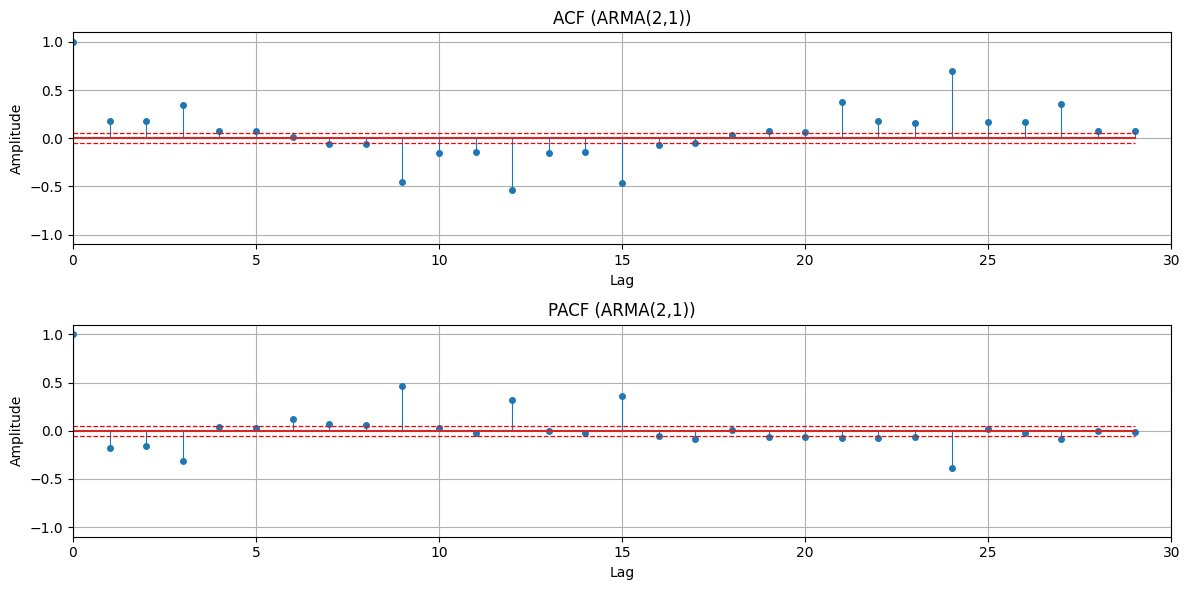

Whiteness test with 5.0% significance
  Ljung-Box-Pierce test: False (white if 2383.09 < 37.65)
  McLeod-Li test:        False (white if 538.80 < 37.65)
  Monti test:            False (white if 1117.21 < 37.65)
  Sign change test:      False (white if 0.33 in [0.47,0.53])


In [132]:
# Analyze input signal x and estimate its ARMA model. Analyze residuals and create w_t and eps_t, 

# plotACFnPACF(x, titleStr='No Model')

## The AR(1) looks white to me and passes the test, but ofc I know it was an ARMA(1,2) and the Mozquisto says ARMA(1,2)
# x_model = estimateARMA(x, A=1, C=0, titleStr='AR(1)')

## The ARMA(1,2) is definitely white, but the coefficients are different than Mozquisto despite them being in the interval and close to the chosen values
x_model = estimateARMA(x, A=1, C=2, titleStr='ARMA(2,1)')

We then pre-whiten $y_t$, creating $\epsilon_t$. Next, we compute the CCF from $w_t$ to $\epsilon_t$. It should be stressed that we *only* use the pre-whitened signals to form this CCF. These signals are then not used in any of the remaining steps.

False


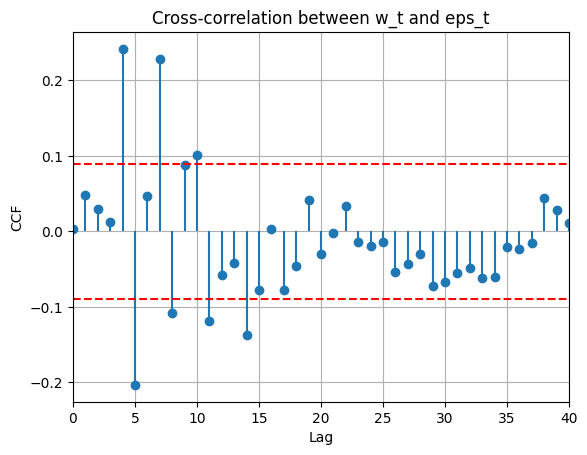

In [ ]:
# Compute and plot cross-correlation between w_t and eps_t

## w_t are the residuals of the model
w_t2 = x_model.resid
w_t = signal.lfilter(x_model.A, x_model.C, x); w_t = w_t[1:]
eps_t = signal.lfilter(x_model.A, x_model.C, y); eps_t = eps_t[1:]
print((w_t != w_t2).sum() > 0)

lags, ccf_vals = compute_ccf(w_t, eps_t, maxlag=40)
fig, ax = plt.subplots()
ax.stem(lags, ccf_vals, basefmt=' ')
condInt = 2 / np.sqrt(len(w_t))
ax.axhline(condInt, color='r', linestyle='--', label='95% confidence')
ax.axhline(-condInt, color='r', linestyle='--')
ax.set_xlabel('Lag')
ax.set_ylabel('CCF')
ax.set_title('Cross-correlation between w_t and eps_t')
ax.set_xlim(0, 40)
plt.grid(True)
plt.show()


"""
In this plot I see that the first non-zero value is at k = 4, hence d = 4. There is a ringing/sinusodial, hence
I assume r = 2. The highest value is found at 4, hence s = 0. Therefore we ahve a (d,r,s) = (4,2,0)
"""



As the estimated CCF now yields an estimate of the impulse response, $H(z)$, we can proceed to use this to determine suitable model orders for the delay, and the $B(z)$ and $A_2(z)$ polynomials using Table 4.7 in the textbook. Use `PEM` ( one can also use the`estimateBJ`) to estimate your model, where the delay may be added to `B` by adding $d$ zeros in the beginning of the vector. If the model orders are suitable, the CCF between the input, $x_t$, and the residual $\tilde{e}_t$ (defined below) should be uncorrelated.

**Task:** Analyze the CCF of $w_t$ to $\epsilon_t$ to find the model orders of the transfer function. Calculate the residual $\tilde{e}_t$ and verify that it is uncorrelated with $x_t$. Also, analyze the residual using the regular basic analysis. Can you conclude that $\tilde{e}_t$ is white noise? Should it be?

**QUESTION 2:** In Mozquizto, answer question 2.

In [46]:
d, r, s = (4, 2, 0)
B_init = [0] * d + [1]
A2_init = [1, 1, 1]
C1_init = [1]
A1_init = [1]

model_ba2 = PEM(y, x, B=B_init, F=A2_init, C=C1_init, D=A1_init)
B_free = [0, 0, 0, 0, 1]
A2_free = [0, 1, 1]
C1_free = None
A1_free = None
model_ba2.set_free_params(B_free=B_free, F_free=A2_free, C_free=C1_free, D_free=A1_free)
Mba2 = model_ba2.fit()
etilde = Mba2.resid
Mba2.summary()

Discrete-time BJ model: y(t) = [B(z)/F(z)]x(t) + e(t)

B(z) = 0.4038(±0.0222)·z⁻⁴
F(z) = 1.0 + 0.899(±0.0207)·z⁻¹ + 0.7762(±0.0204)·z⁻²

Polynomial orders: nB = 4    nF = 2
Number of free coefficients: 3
Fit to estimation data (NRMSE): 27.37%
FPE : 2.705  MSE : 2.703
AIC : 1906.818   BIC : 1919.437



#### Step 2: Check the input contribution

It is always wise to examine how much of the output signal that is described by the input signal. To examine this, plot the output as compared to the filtered input. Note that we, as usual, need to remove the corrupt samples from the filtered input, and thus also from `y` to keep the signals in sync.



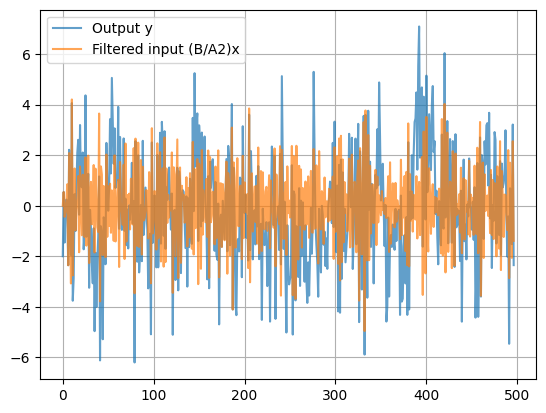

In [47]:

xfilt = signal.lfilter(Mba2.B, Mba2.F, x)
y_cut = y[len(Mba2.F):]
xfilt_cut = xfilt[len(Mba2.F):]

fig, ax = plt.subplots()
ax.plot(y_cut, label='Output y', alpha=0.7 )
ax.plot(xfilt_cut, label='Filtered input (B/A2)x', alpha=0.7)
ax.legend()
ax.grid(True)
plt.show()



Clearly, these two signals will rarely be the same (or even close to the same), but you want to see that the (filtered) input is indeed describing a significant part of the output - and that it is in phase with the output, so that when you subtract the two (below), the residual ($\tilde{e}_t$) becomes "smaller" than the original output. It should be stressed that our model is not yet completed, so the here used polynomials will not be in their final form - but as it can happen that one "loses the input", i.e., the input becomes less important, when one proceed with the modelling, it is wise to check this part already now - and then do so again when the model is complete, to ensure that one still use the input properly. If this is not the case, you are creating a problem and need to redo the first steps...

In [49]:
var_y = np.var(y)
var_etilde = np.var(etilde) 

print(f'var_y: {var_y}')
print(f'var_etilde: {var_etilde}')

var_y: 5.124488395523343
var_etilde: 2.6729113032684952




#### Step 3: Model the ARMA part

We have now modeled $y_t$ as a function of the input $x_t$, but have not yet formed a model of the ARMA-process in the BJ model, i.e., modeled the polynomials $C_1(z)$ and $A_1(z)$. Therefore, defining the ARMA-part as

$$
\tilde{e}_t = \frac{C_1(z)}{A_1(z)} e_t
$$

we use the estimated polynomials $B(z)$ and $A_2(z)$ and estimate $\tilde{e}_t$ as

$$
\tilde{e}_t = y_t -  \frac{\hat{B}(z)z^{-\hat{d}}}{\hat{A}_2(z)} x_t
$$

By filtering out the input-dependent part of the process $y_t$, we may then determine suitable orders for the polynomials $C_1(z)$ and $A_1(z)$ using the standard ARMA-modeling procedure.

**Task:** Use the estimates of the polynomials $B(z)$ and $A_2(z)$ obtained for the pre-whitened data, plot the filtered input as compared to the output, and form $\tilde{e}_t$. Determine suitable model orders for $A_1(z)$ and $C_1(z)$. Was all dependence from $x_t$ removed in $\tilde{e}_t$? (For real data, there is often remaining dependencies in the data - this should not come as a surprise given the simplistic models we use. Do not let this worry you, rather proceed to examine if the model works. If it does, then this is likely nothing to worry about...)

**QUESTION 3:** In Mozquizto, answer question 3.

Discrete-time AR model: A(z)y(t) = e(t)

A(z) = 1.0 - 0.7089(±0.0317)·z⁻¹

Polynomial orders: nA = 1
Number of free coefficients: 1
Fit to estimation data (NRMSE): 28.97%
FPE : 1.351  MSE : 1.348
AIC : 1554.706   BIC : 1558.911



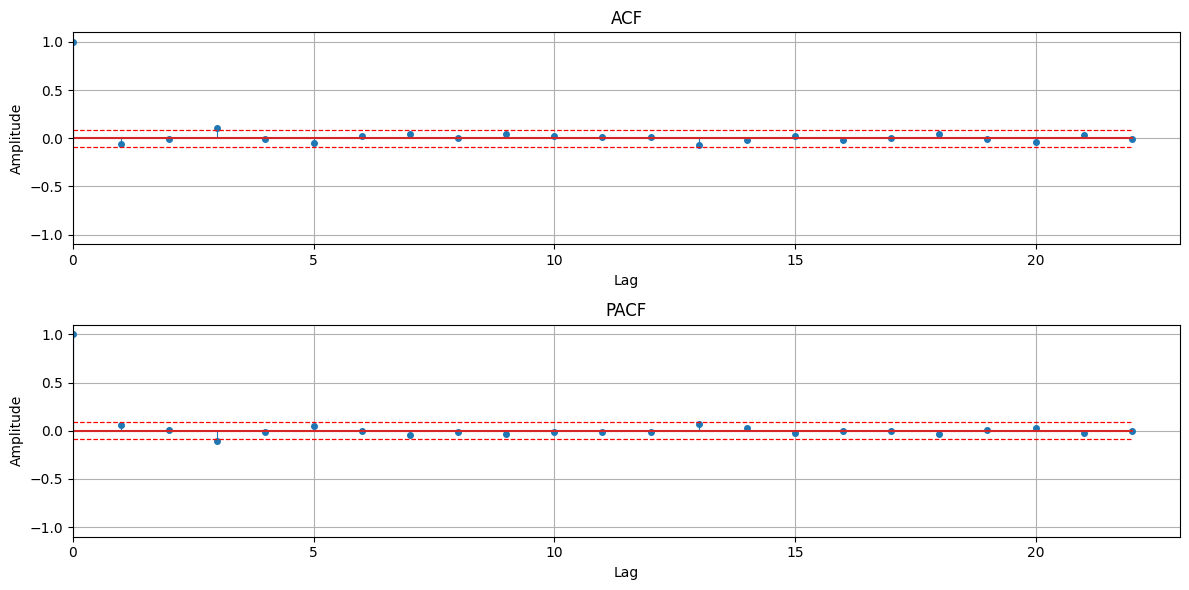

Whiteness test with 5.0% significance
  Ljung-Box-Pierce test: True (white if 19.68 < 37.65)
  McLeod-Li test:        False (white if 40.76 < 37.65)
  Monti test:            True (white if 18.79 < 37.65)
  Sign change test:      True (white if 0.49 in [0.46,0.54])


In [53]:
# analyze the etilde and estimate order for A1, C1 
arma = estimateARMA(etilde, A=1, C=0)

#### Step 4: Estimate complete BJ model

Finally, now having determined all the polynomial orders in our model, we estimate all polynomials all together using the estimation function. Here, `ehat` is the estimate of the noise process e_t; notice that this is not the same process as $\tilde{e}_t$ (which is the filtered version of e_t as shown above). The intermediate residual from the previous steps is stored in the variable `etilde`.

In [ ]:
B_init = [0, 0, 0, 0, 1]
A2_init = [1, 1, 1]
C1_init = [1]
A1_init = [1, 1]

model_boxj = PEM(y, x, B=B_init, F=A2_init, C=C1_init, D=A1_init)
B_free = [0, 0, 0, 0, 1]
A2_free = [1, 1, 1]
C1_free = [0]
A1_free = [0, 1]
model_boxj.set_free_params(B_free=B_free, F_free=A2_free, C_free=C1_free, D_free=A1_free)
MboxJ = model_boxj.fit()
ehat = MboxJ.resid
MboxJ.summary()



Discrete-time BJ model: y(t) = [B(z)/F(z)]x(t) + [1/D(z)]e(t)

B(z) = 0.4019(±0.0101)·z⁻⁴
D(z) = 1.0 - 0.7068(±0.0317)·z⁻¹
F(z) = 1.0 + 0.8998(±0.0099)·z⁻¹ + 0.7771(±0.0095)·z⁻²

Polynomial orders: nB = 4    nD = 1    nF = 2
Number of free coefficients: 4
Fit to estimation data (NRMSE): 48.68%
FPE : 1.369  MSE : 1.35
AIC : 1564.291   BIC : 1581.118





#### Step 5: Final verification

Check again so that you are still using the input properly by forming the plot in step 2 above. Have you "lost the input" as compared to before?

**Task:** Are the parameter estimates significantly different from zero? Can you conclude that the residual is white noise, uncorrelated with the input signal? If not, can you twiddle with the model slightly to improve the residual?

**Be prepared to answer these questions when discussing with the examiner at the computer exercise!**

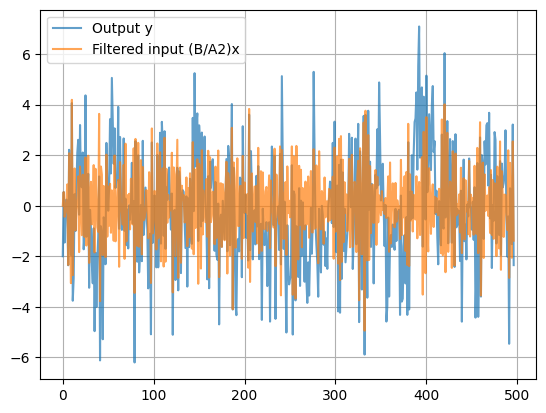

var_y: 5.124488395523343
var_etilde: 2.6729113032684952
var_ehat: 1.347146104355864
Whiteness test with 5.0% significance
  Ljung-Box-Pierce test: True (white if 19.80 < 37.65)
  McLeod-Li test:        False (white if 40.81 < 37.65)
  Monti test:            True (white if 18.61 < 37.65)
  Sign change test:      True (white if 0.49 in [0.46,0.54])


In [ ]:
# Analyze the model
xfilt = signal.lfilter(MboxJ.B, MboxJ.F, x)
y_cut = y[len(MboxJ.F):]
xfilt_cut = xfilt[len(MboxJ.F):]

fig, ax = plt.subplots()
ax.plot(y_cut, label='Output y', alpha=0.7 )
ax.plot(xfilt_cut, label='Filtered input x', alpha=0.7)
ax.legend()
ax.grid(True)
plt.show()


# Checking variance reduction
var_y = np.var(y)
var_etilde = np.var(etilde) 
var_ehat = np.var(ehat) 

print(f'var_y: {var_y}')
print(f'var_etilde: {var_etilde}')
print(f'var_ehat: {var_ehat}')

# Check for whiteness
whiteness_test(ehat)


## TODO WITH RESIDUALS
lags, ccf_vals = compute_ccf(w_t, eps_t, maxlag=40)


### 2.2 Prediction of ARMA-processes

In this section, we examine how to predict future values of a process, using temperature measurements from the Swedish city Svedala. The temperature data is sampled every hour during a period in April and May 1994, with its (estimated) mean value subtracted (11.35°C).

Load the measurements ` svedala`. Suitable model parameters for the data set are:

```python
A = [ 1, -1.79, 0.84 ]
C = [ 1, -0.18, -0.11 ]
```

To make a $k$-step prediction, $\hat{y}_{t+k \mid t}$, one needs to solve the equation

$$
C(z) \hat{y}_{t+k \mid t}=G_k(z)y_t 
$$

This can be done using the filter command (remember to remove the initial samples after using the command `signal.lfilter`):

```python
yhat_k = signal.lfilter(Gk, C, y)
```

where $G_k$ is obtained from the Diophantine equation

$$
C(z)=A(z)F_k(z)+z^{-k}G_k(z).
$$

Here, we have included the desired prediction range, $k$, in the polynomials $G_k(z)$ and $F_k(z)$ to stress that you will need a different polynomial for each $k$. Thus, if you wish to predict two steps ahead into the future, forming both $\hat{y}_{t+1 | t}$ and $\hat{y}_{t+2 | t}$, you will need to use both $G_1(z)$ and $G_2(z)$ to construct these estimates.

To solve the Diophantine equation, you can use the provided function `polydiv`:

```python
[Fk, Gk] = polydiv(C, A, k)
```

The prediction error is formed as

$$
y_{t+k}-\hat{y}_{t+k \mid t} = F_k(z) e_{t+k},
$$

Note in particular that the prediction error will (for a perfect model) have the form of an MA($k-1$) process with the generating polynomial

$$
F_k(z)=1+f_1z^{-1} + \cdots +f_{k-1}z^{-(k-1)}.
$$

Note also that if $k=1$, then $F_1(z)=1$, suggesting that the prediction error should be a white noise, and that, for this case, the prediction error thus allows for an estimate of the noise variance.

**QUESTION 4:** In Mozquizto, answer question 4.

**Task:** In the following questions, examine the $k$-step prediction using $k=3$ and $k=26$. Answer the following questions:

1. What is the estimated mean and the expectation of the prediction error for each of these cases?
2. Assuming that the estimated noise variance is the true one, what is the theoretical variance of the prediction error? Using the same noise variance, what is the estimated variance of the prediction error? Comment on the differences in these variances.
3. For each of the cases, determine the theoretical 95% confidence interval of the prediction errors?
4. How large percentage of the prediction errors are outside the 95% confidence interval? A useful trick might be to use `sum(res>c)` to compute how many elements in `res` that are greater than `c`.
5. Plot the process and the predictions in the same plot, and in a separate figure, plot the residuals. Check if the sequence of residuals behaves as an MA($k-1$) process by, e.g., estimating its covariance function using `covf`. If it does not, is it close?

**Be prepared to answer these questions when discussing with the examiner at the computer exercise!**

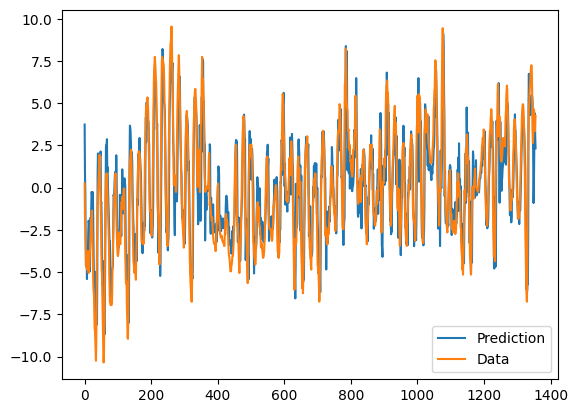

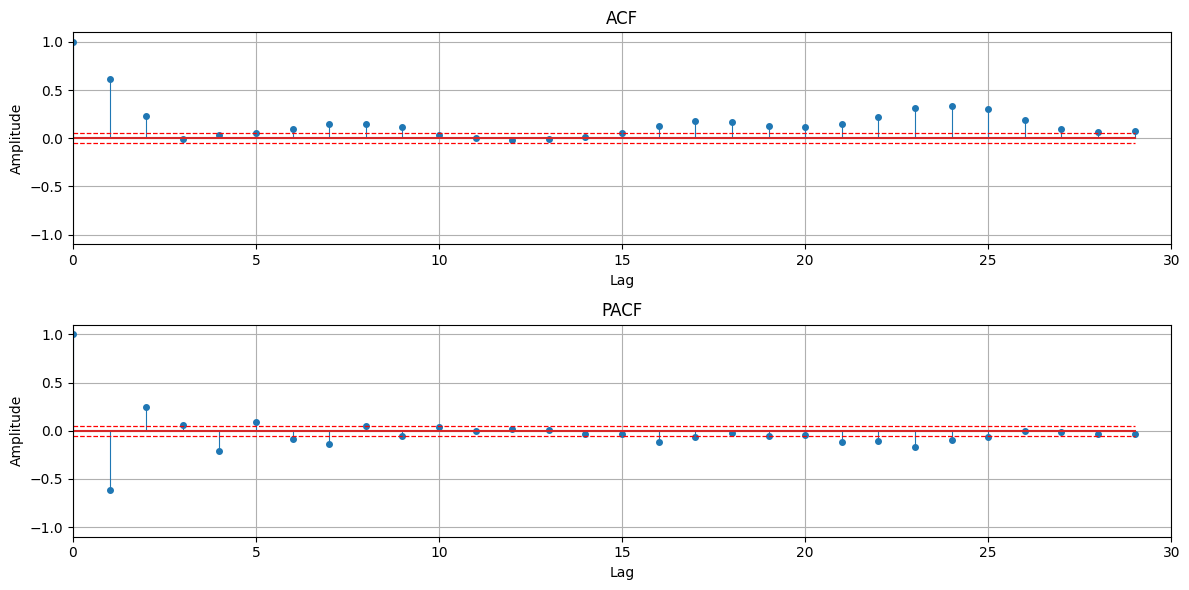

Var(ehat): 2.5894470244210503 
Gk: [ 0.00000000e+00 -5.55111512e-17  9.71445147e-17  2.10570100e+00
 -1.62279600e+00]
len(Gk): 5
Estimate var(noise): 2.0684888692682733e+32 
Inside ci %: 0.9380530973451328


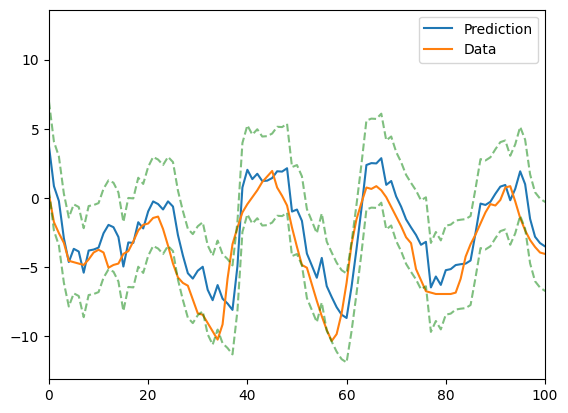

In [108]:
# Load svedala temperature data
mat = scipy.io.loadmat(os.path.join(DATA_DIR, 'svedala.mat'))
svedala = mat['svedala'].flatten()
y = svedala

# Setup
A = [ 1, -1.79, 0.84 ]
C = [ 1, -0.18, -0.11 ]
k = 3

# Create prediciton
[Fk, Gk] = polydiv(C, A, k) 
yhat_k = signal.lfilter(Gk, C, y)
yhat_k = yhat_k[len(Gk):]
y = y[len(Gk):]

plt.plot(yhat_k, label='Prediction')
plt.plot(y, label='Data')
plt.legend()
# plt.xlim(0, 100)

# Create and plot residuals
ehat = y - yhat_k
plotACFnPACF(ehat)
denom = sum(coeff**2 for coeff in Gk[:k])
var_noise = np.var(ehat) / denom if k > 1 else np.var(ehat)
print(f'Var(ehat): {np.var(ehat)} ')
print(f'Gk: {Gk}')
print(f'len(Gk): {len(Gk)}')
print(f'Estimate var(noise): {var_noise} ')


# Confidence interval
u = 2
factor = np.sqrt(sum(g**2 for g in Gk[:k])) if k > 1 else 1
lb = [estim - u*factor*np.sqrt(var_noise) for estim in yhat_k]
ub = [estim + u*factor*np.sqrt(var_noise) for estim in yhat_k]
inside_ci = [ low < elem < high for low, high, elem in zip(lb, ub, y)]
print(f'Inside ci %: {sum(inside_ci) / len(inside_ci)}')

plt.plot(yhat_k, label='Prediction')
plt.plot(y, label='Data')
plt.plot(lb, color='green', linestyle='--', alpha=0.5)
plt.plot(ub, color='green', linestyle='--', alpha=0.5)
plt.xlim(0, 100)
plt.plot()
plt.legend()


### 2.3 Prediction of ARMAX-processes

When predicting ARMAX-processes, one needs to consider also the external input. We will now make use of an additional temperature measurement done at the airport Sturup. The Swedish Meteorological and Hydrological Institute (SMHI) has made a 3-step predictions of the temperature for Sturup, which may be used as an external input signal to our temperature measurements in Svedala. (The provided signals are in sync, so the value at time $t$ in Sturup is the predicted value corresponding to that time. Thus, you do not need to shift the input.)

Load the SMHI predictions `sturup`, and set the model parameters to be:

```python
A = [ 1, -1.49, 0.57 ]
B = [ 0, 0, 0, 0.28, -0.26 ]
C = [ 1 ]
```

How large is the delay in this temperature model? How do you know?

Form the $k$-step predictor of the temperature at Svedala using the Svedala predictions as input using

$$
C(z)\hat{y}_{t+k \mid t} = B(z)F_k(z)x_t+G_k(z)y_t,
$$

where $F_k(z)$ and $G_k(z)$ are computed as indicated above. (You should thus not construct a model for the input or output in this example, but instead just use the given polynomials.) The $k$-step prediction is then formed as

$$
\hat{y}_{t+k | t} = \hat{F}_k(z) \hat{x}_{t+k|t} + \frac{\hat{G}_k(z)}{C(z)} x_t + \frac{G_k(z)}{C(z)} y_t 
$$

where $\hat{x}_{t+k}$ denotes the predicted future inputs, and the polynomials $\hat{F}_k(z)$ and $\hat{G}_k(z)$ are given by the Diophantine equation

$$
B(z)F_k(z)=C(z) \hat{F}_k(z) + z^{-k}\hat{G}_k(z)
$$

In the prediction, the two first terms represents the contribution of the input signal, with the first term being the prediction of the input signal (in this example, this is thus the prediction of the "predicted temperature"; perhaps better not to think about this too much :-)), whereas the third term is from the ARMA part of the process. Form predictions for both $k=3$ and $k=26$.

**QUESTION 5:** In Mozquizto, answer question 5.

**Important:** A common error is that one forgets to add the term $\hat{F}_k(z) \hat{x}_{t+k|t}$ when forming the prediction $\hat{y}_{t+k | t}$. Note that it is *only* in cases when the input cannot be predicted, i.e., when $x_t$ is a white process, that one omits the $\hat{F}_k(z) \hat{x}_{t+k|t}$ term from the prediction. Otherwise, when $x_t$ has any form of structure, it may be predicted, and then the term *should* be included. (To avoid making this error, it is recommended that you *always* include the term; when predicting $\hat{x}_{t+k|t}$ in the (rare) white noise case, this will of course be zero, so you will just add a zero sequence, which will not corrupt your results, but then you will not forget to add it, which will certainly cause problematic results (this typically appears as predictions that seem to have the correct pattern, but with a too low amplitude).)

**Important:** Another common error is that one removes a different number of initial samples when creating $\frac{\hat{G}_k(z)}{C(z)} x_t$ and $\hat{F}_k(z) \hat{x}_{t+k|t}$; as discussed before, one needs to remove the same number of samples as the order of the denominator polynomial to avoid the problem of the initialization of the filter. However, to avoid the sequences to get out of sync with each other, one should remove the *same* number of samples from both sequences, so that one removes the maximum of the number of samples that are required to be removed from either sequence.

**Task:** Using $k=3$, what is the variance of the prediction errors? Plot the process, the prediction and the prediction errors.

A common error when making predictions of ARMAX and BJ processes is to forget to add the $\hat{F}_k(z) \hat{x}_{t+k|t}$ term. Plot this erroneous prediction and the corresponding prediction errors. Can you see how this error appears in your prediction?

**Be prepared to answer these questions when discussing with the examiner at the computer exercise!**

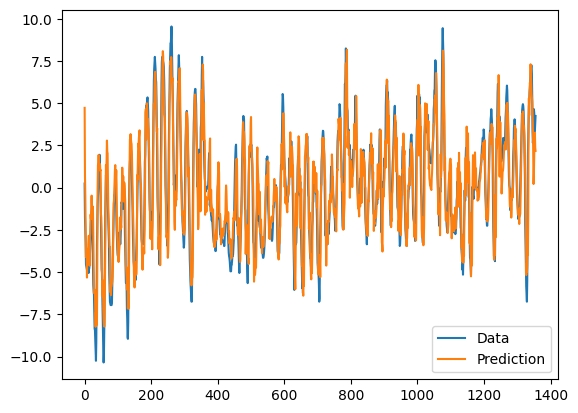

[0. 0. 0.]


In [137]:
import numpy as np
import scipy.io, os
from scipy import signal
import matplotlib.pyplot as plt

# Load data
mat_sturup = scipy.io.loadmat(os.path.join(DATA_DIR, 'sturup.mat'))
x = mat_sturup['sturup'].flatten()

mat = scipy.io.loadmat(os.path.join(DATA_DIR, 'svedala.mat'))
y = mat['svedala'].flatten()

# Setup ARMAX model
k = 3
A = [1, -1.49, 0.57]
B = [0, 0, 0, 0.28, -0.26]  # delay = 3
C = [1]

# Compute polynomials
F, G = polydiv(C, A, k)
Fhat, Ghat = polydiv(np.convolve(F, B), C, k)

# Prediction
yhat_k =  signal.lfilter(Fhat, [1], x) + signal.lfilter(Ghat, C, x) + signal.lfilter(G, C, y)
yhat_k = yhat_k[len(G):]
y_filtered = y[len(G):]

plt.plot(y_filtered, label='Data')
plt.plot(yhat_k, label='Prediction')
plt.legend()
# plt.xlim(0, 200)
plt.show()


print(Fhat)

### 2.4 (Optional) Examine the project data

Examining the project data, proceed to build a model for the input signal (you will need to do this for each of the inputs you wish to use). Do you need to use a transform of the data? Is the resulting model residual white? Pre-whiten the input and output and form the CCF. What seems to be a suitable model? Plot the output as compared to the filtered input - are you explaining a significant part of the output? Estimate the resulting BJ model - is the model residual (reasonably) white?

Often, these steps take quite some time - and sometimes one is better off just guessing suitable model orders for $B(z)$ and $A_2(z)$... If it seems problematic to use the above scheme, try with a simple model, using only $B(z) = b_0$ and vary the delay to see what seems to work - then perhaps add a $b_1$ term? Perhaps try some other term? Maybe you can get better results by adding a simple $A_2(z)$ polynomial? Can you remove some coefficients? Be careful to add many parameters here, these polynomials should likely be small.

Having now formed a decent model, try to form a one-step prediction using your model. Plot the predicted signal as compared to the output and the naive predictor. Does your model seem to work? Is the prediction residual white? Compare the residual variance for your predictor to that of the naive predictor; did you manage to beat the naive predictor?

**Hint:** The above steps will typically form key steps in the project, so the time you spend on this now will be time saved later on...